# DwC Events. Keister Zooplankton Hood Canal 2012-13 data

University of Washington Pelagic Hypoxia Hood Canal project, Zooplankton dataset.   
Alignment of dataset to Darwin Core (DwC) for NANOOS, https://www.nanoos.org. This data alignment work, including this Jupyter notebook, are described in the GitHub repository https://github.com/nanoos-pnw/obis-keisterhczoop. See [notebooks-notes.md](https://github.com/nanoos-pnw/obis-keisterhczoop/blob/main/notebooks-notes.md) and [README.md](https://github.com/nanoos-pnw/obis-keisterhczoop/blob/main/README.md).   

Emilio Mayorga, https://github.com/emiliom   

## Goals and scope of this notebook

Parse the source data to define and pull out 3 event "types": `cruise`, `stationVisit` and `sample`. The DwC event table is populated sequentially for each of those event types, in that order, from the most temporally aggregated (cruise) to the most granular (sample). Columns are populated differently depending on the event type. The notebook generates the DwC "event" file `DwC_event.csv`.

## Settings

In [1]:
from datetime import datetime
import json
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

from data_preprocess import read_and_parse_sourcedata

In [2]:
data_pth = Path(".")

Set to `True` when debugging. `csv` ﬁles will not be exported when `debug_no_csvexport = True`

In [3]:
debug_no_csvexport = False

## Process JSON file containing common mappings and strings

In [4]:
with open(data_pth / 'common_mappings.json') as f:
    common_mappings = json.load(f)

In [5]:
DatasetCode = common_mappings['datasetcode']
cruises = common_mappings['cruises']
stations = common_mappings['stations']
net_tow = common_mappings['net_tow']

iso8601_format = common_mappings['iso8601_format']
CRS = common_mappings['CRS']

## Pre-process data from csv for Event table

### Read the pre-processed csv file

`usecols` defines the columns that will be kept and the order in which they'll be organized

In [6]:
usecols = [
    'sample_code', 'mesh_size', 'FWC_DS', 
    'station', 'latitude', 'longitude', 
    'date', 'time_start', 'time', 'day_night', 
    'depth_min', 'depth_max',
    'net_code', 'extra_sample_token'
]

eventsource_df = read_and_parse_sourcedata()[usecols]

In [7]:
len(eventsource_df)

6866

In [8]:
eventsource_df.head()

,sample_code,mesh_size,FWC_DS,station,latitude,longitude,date,time_start,time,day_night,depth_min,depth_max,net_code,extra_sample_token
0,20131003DBDm2_200,200,DS,DB,47.378,-123.117,20131003,14:11,2013-10-03 14:11:00-07:00,Day,30.0,56.0,m2,
1,20130906DBiDm1_200,200,FWC,DB,47.378,-123.117,20130906,16:17,2013-09-06 16:17:00-07:00,Day,0.0,60.0,m1,i
2,20131003DBDm1_200,200,FWC,DB,47.378,-123.117,20131003,14:11,2013-10-03 14:11:00-07:00,Day,0.0,56.0,m1,
3,20131003DBDm1_200,200,FWC,DB,47.378,-123.117,20131003,14:11,2013-10-03 14:11:00-07:00,Day,0.0,56.0,m1,
4,20120614DBDm3_200,200,DS,DB,47.378,-123.117,20120614,17:25,2012-06-14 17:25:00-07:00,Day,9.0,20.0,m3,


### Remove duplicates

In [9]:
eventsource_df = eventsource_df.drop_duplicates().sort_values(by='sample_code').reset_index(drop=True)

In [10]:
len(eventsource_df)

271

### sample_code extra characters (extra sub-code -- see Amanda's explanation)

In [11]:
len(eventsource_df.sample_code.unique())

271

In [12]:
eventsource_df.sample_code.str.len().value_counts()

17    220
18     43
19      6
14      1
20      1
Name: sample_code, dtype: int64

In [13]:
# eventsource_df[eventsource_df.sample_code.str.len().isin([14,19,20])].head(60)

In [14]:
# eventsource_df[eventsource_df.sample_code.str.len() == 18].head(50)

## Create empty Event dataframe

Records from each event type will be appended to this dataframe, by "type". The type is encoded in the `eventType` column, not in the DwC `type` column, which is not used here explicitly (the type is `Event`).

In [15]:
event_cols_dtypes = np.dtype(
    [
        ('eventID', str),
        ('eventType', str), 
        ('parentEventID', str),
        ('eventDate', str), 
        ('locationID', str),
        ('locality', str),
        ('decimalLatitude', float),
        ('decimalLongitude', float),
        ('footprintWKT', str),
        ('geodeticDatum', str),
        ('waterBody', str),
        ('countryCode', str), 
        ('minimumDepthInMeters', float),
        ('maximumDepthInMeters', float),
        ('samplingProtocol', str)
    ]
)

In [16]:
event_df = pd.DataFrame(np.empty(0, dtype=event_cols_dtypes))

## Create cruise events

- Assign cruise code from `cruises` based on `date`
- Use `group_by` to generate cruise `time` start and end
- Come up with cruise `eventID`. Come up with a project/dataset code first
- Populating `event_df` with cruise events

Add cruise-related columns to `eventsource_df`. `date_yyyymm` will be used to link cruise events to stationVisit events

In [17]:
eventsource_df['date_yyyymm'] = eventsource_df['time'].apply(lambda dt: dt.strftime("%Y%m"))
eventsource_df['cruise_code'] = eventsource_df['date_yyyymm'].apply(lambda s: cruises[s])

In [18]:
eventsource_df.head()

,sample_code,mesh_size,FWC_DS,station,latitude,longitude,date,time_start,time,day_night,depth_min,depth_max,net_code,extra_sample_token,date_yyyymm,cruise_code
0,20120611UNDm1_200,200,DS,UN,47.812,-122.807,20120611,14:10,2012-06-11 14:10:00-07:00,Day,16.0,72.0,m1,,201206,CB975
1,20120611UNDm1_335,335,DS,UN,47.812,-122.807,20120611,15:50,2012-06-11 15:50:00-07:00,Day,16.0,40.0,m1,,201206,CB975
2,20120611UNDm2_200,200,DS,UN,47.812,-122.807,20120611,16:53,2012-06-11 16:53:00-07:00,Day,8.0,16.0,m2,,201206,CB975
3,20120611UNDm2_335,335,DS,UN,47.812,-122.807,20120611,15:50,2012-06-11 15:50:00-07:00,Day,8.0,16.0,m2,,201206,CB975
4,20120611UNDm3_200,200,DS,UN,47.812,-122.807,20120611,23:10,2012-06-11 23:10:00-07:00,Day,0.0,8.0,m3,,201206,CB975


### Create cruise footprintWKT and centroid points

In [19]:
cruise_stations_df = eventsource_df[['cruise_code', 'latitude', 'longitude']].drop_duplicates()

In [20]:
cruise_stations_gdf = gpd.GeoDataFrame(
    data=cruise_stations_df,
    geometry=gpd.points_from_xy(cruise_stations_df.longitude, cruise_stations_df.latitude, crs=CRS)
)

len(cruise_stations_gdf)

40

In [21]:
cruise_stations_gdf.head()

,cruise_code,latitude,longitude,geometry
0,CB975,47.812,-122.807,POINT (-122.80700 47.81200)
13,CB975,47.581,-122.986,POINT (-122.98600 47.58100)
15,CB975,47.404,-123.125,POINT (-123.12500 47.40400)
17,CB975,47.378,-123.117,POINT (-123.11700 47.37800)
34,CB979,47.812,-122.807,POINT (-122.80700 47.81200)


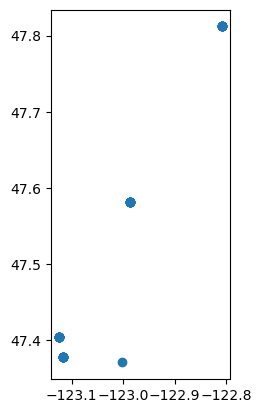

In [22]:
cruise_stations_gdf.plot();

In [23]:
cruise_stations_gdf.cruise_code.value_counts()

CB1007    5
CB975     4
CB979     4
CB982     4
CB986     4
CB988     4
CB1002    4
CB1003    4
CB1005    4
CB1009    3
Name: cruise_code, dtype: int64

Create one convex hull polygon for each cruise

In [24]:
cruise_footprints_gdf = gpd.GeoDataFrame(
    cruise_stations_gdf.groupby(['cruise_code'])['geometry'].apply(
        lambda geom: geom.unary_union.convex_hull)
)
cruise_footprints_gdf['footprintWKT'] = cruise_footprints_gdf.geometry.to_wkt()
# Add footprint centroid latitude and longitude
cruise_footprints_gdf['decimalLongitude'] = cruise_footprints_gdf.centroid.x.round(3)
cruise_footprints_gdf['decimalLatitude'] = cruise_footprints_gdf.centroid.y.round(3)
cruise_footprints_gdf.reset_index(drop=False, inplace=True)

In [25]:
cruise_footprints_gdf

,cruise_code,geometry,footprintWKT,decimalLongitude,decimalLatitude
0,CB1002,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.016,47.531
1,CB1003,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.016,47.531
2,CB1005,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.016,47.531
3,CB1007,"POLYGON ((-123.00300 47.37100, -123.11700 47.3...","POLYGON ((-123.003 47.371, -123.117 47.378, -1...",-122.983,47.522
4,CB1009,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.076,47.454
5,CB975,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.016,47.531
6,CB979,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.016,47.531
7,CB982,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.016,47.531
8,CB986,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.016,47.531
9,CB988,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.016,47.531


**NOTE:** It would be nice to add the R2R cruise code (eg, "CB1002"; `cruise_code` column) to the event table, ideally as an R2R url (eg, https://www.rvdata.us/search/cruise/CB988). But in what column? `eventRemarks`?

In [26]:
cruise_df = eventsource_df.groupby(['cruise_code', 'date_yyyymm']).agg({
    'time':['min', 'max'],
    'depth_min':['min'],
    'depth_max':['max'],
})
cruise_df.columns = ["_".join(stat) for stat in cruise_df.columns.ravel()]
cruise_df = (
    cruise_df.
    rename(columns={'depth_min_min':'minimumDepthInMeters', 'depth_max_max':'maximumDepthInMeters'})
    .sort_values(by='date_yyyymm')
    .reset_index(drop=False)
)
cruise_df

/tmp/ipykernel_586217/1398826441.py:6: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  cruise_df.columns = ["_".join(stat) for stat in cruise_df.columns.ravel()]


,cruise_code,date_yyyymm,time_min,time_max,minimumDepthInMeters,maximumDepthInMeters
0,CB975,201206,2012-06-11 14:10:00-07:00,2012-06-14 22:50:00-07:00,0.0,145.0
1,CB979,201207,2012-07-09 16:40:00-07:00,2012-07-13 00:17:00-07:00,0.0,158.0
2,CB982,201208,2012-08-06 15:35:00-07:00,2012-08-10 00:29:00-07:00,0.0,165.0
3,CB986,201209,2012-09-02 14:32:00-07:00,2012-09-05 23:19:00-07:00,0.0,165.0
4,CB988,201210,2012-10-01 13:35:00-07:00,2012-10-04 22:53:00-07:00,0.0,164.0
5,CB1002,201306,2013-06-10 17:13:00-07:00,2013-06-13 23:04:00-07:00,0.0,160.0
6,CB1003,201307,2013-07-08 22:32:00-07:00,2013-07-11 18:28:00-07:00,0.0,160.0
7,CB1005,201308,2013-08-05 16:09:00-07:00,2013-08-08 23:01:00-07:00,0.0,162.0
8,CB1007,201309,2013-09-03 14:38:00-07:00,2013-09-30 21:18:00-07:00,0.0,152.0
9,CB1009,201310,2013-10-01 20:57:00-07:00,2013-10-03 20:16:00-07:00,0.0,158.0


In [27]:
# This form is for populating eventDate with an iso8601 interval
#     lambda row: "{}/{}".format(row['time_min'].strftime(iso8601_format), 
#                                row['time_max'].strftime(iso8601_format)),

cruise_df['eventDate'] = cruise_df.apply(
    lambda row: "{}".format(row['time_min'].strftime(iso8601_format)),
    axis=1
)

In [28]:
cruise_df = cruise_df.merge(cruise_footprints_gdf, on='cruise_code')

In [29]:
cruise_df['eventID'] = DatasetCode + "_" + cruise_df['cruise_code']
cruise_df['eventType'] = 'cruise'
cruise_df['geodeticDatum'] = CRS
cruise_df['waterBody'] = 'Hood Canal, Puget Sound'
cruise_df['countryCode'] = 'US'

In [30]:
cruise_df.head()

,cruise_code,date_yyyymm,time_min,time_max,minimumDepthInMeters,maximumDepthInMeters,eventDate,geometry,footprintWKT,decimalLongitude,decimalLatitude,eventID,eventType,geodeticDatum,waterBody,countryCode
0,CB975,201206,2012-06-11 14:10:00-07:00,2012-06-14 22:50:00-07:00,0.0,145.0,2012-06-11T14:10:00-0700,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.016,47.531,UWPHHCZoop_CB975,cruise,EPSG:4326,"Hood Canal, Puget Sound",US
1,CB979,201207,2012-07-09 16:40:00-07:00,2012-07-13 00:17:00-07:00,0.0,158.0,2012-07-09T16:40:00-0700,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.016,47.531,UWPHHCZoop_CB979,cruise,EPSG:4326,"Hood Canal, Puget Sound",US
2,CB982,201208,2012-08-06 15:35:00-07:00,2012-08-10 00:29:00-07:00,0.0,165.0,2012-08-06T15:35:00-0700,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.016,47.531,UWPHHCZoop_CB982,cruise,EPSG:4326,"Hood Canal, Puget Sound",US
3,CB986,201209,2012-09-02 14:32:00-07:00,2012-09-05 23:19:00-07:00,0.0,165.0,2012-09-02T14:32:00-0700,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.016,47.531,UWPHHCZoop_CB986,cruise,EPSG:4326,"Hood Canal, Puget Sound",US
4,CB988,201210,2012-10-01 13:35:00-07:00,2012-10-04 22:53:00-07:00,0.0,164.0,2012-10-01T13:35:00-0700,"POLYGON ((-123.11700 47.37800, -123.12500 47.4...","POLYGON ((-123.117 47.378, -123.125 47.404, -1...",-123.016,47.531,UWPHHCZoop_CB988,cruise,EPSG:4326,"Hood Canal, Puget Sound",US


### Populate (append to) the `event_df` table with the cruise events

In [31]:
event_df = pd.concat(
    [
        event_df,
        cruise_df[[
            'eventID', 'eventType', 'eventDate', 
            'decimalLatitude', 'decimalLongitude', 'footprintWKT', 'geodeticDatum', 
            'waterBody', 'countryCode', 'minimumDepthInMeters', 'maximumDepthInMeters'
        ]]
    ],
    ignore_index=True
)

In [32]:
event_df.head()

,eventID,eventType,parentEventID,eventDate,locationID,locality,decimalLatitude,decimalLongitude,footprintWKT,geodeticDatum,waterBody,countryCode,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol
0,UWPHHCZoop_CB975,cruise,NaN,2012-06-11T14:10:00-0700,NaN,NaN,47.531,-123.016,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,145.0,NaN
1,UWPHHCZoop_CB979,cruise,NaN,2012-07-09T16:40:00-0700,NaN,NaN,47.531,-123.016,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,158.0,NaN
2,UWPHHCZoop_CB982,cruise,NaN,2012-08-06T15:35:00-0700,NaN,NaN,47.531,-123.016,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,165.0,NaN
3,UWPHHCZoop_CB986,cruise,NaN,2012-09-02T14:32:00-0700,NaN,NaN,47.531,-123.016,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,165.0,NaN
4,UWPHHCZoop_CB988,cruise,NaN,2012-10-01T13:35:00-0700,NaN,NaN,47.531,-123.016,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,164.0,NaN


## Create stationVisit events

- Use cruise `eventID` from `eventsource_df` as stationVisit `parentEventID`
- Add `stationvisit_code` to `eventsource_df`, for use by the next event type (sample)

In [33]:
eventsource_df['stationvisit_code'] = (
    eventsource_df['date'].astype(str) + eventsource_df['station'] + eventsource_df['day_night'].str.get(0)
)

In [34]:
eventsource_df.head()

,sample_code,mesh_size,FWC_DS,station,latitude,longitude,date,time_start,time,day_night,depth_min,depth_max,net_code,extra_sample_token,date_yyyymm,cruise_code,stationvisit_code
0,20120611UNDm1_200,200,DS,UN,47.812,-122.807,20120611,14:10,2012-06-11 14:10:00-07:00,Day,16.0,72.0,m1,,201206,CB975,20120611UND
1,20120611UNDm1_335,335,DS,UN,47.812,-122.807,20120611,15:50,2012-06-11 15:50:00-07:00,Day,16.0,40.0,m1,,201206,CB975,20120611UND
2,20120611UNDm2_200,200,DS,UN,47.812,-122.807,20120611,16:53,2012-06-11 16:53:00-07:00,Day,8.0,16.0,m2,,201206,CB975,20120611UND
3,20120611UNDm2_335,335,DS,UN,47.812,-122.807,20120611,15:50,2012-06-11 15:50:00-07:00,Day,8.0,16.0,m2,,201206,CB975,20120611UND
4,20120611UNDm3_200,200,DS,UN,47.812,-122.807,20120611,23:10,2012-06-11 23:10:00-07:00,Day,0.0,8.0,m3,,201206,CB975,20120611UND


In [35]:
stationvisit_df = eventsource_df.groupby(
    ['date', 'day_night', 'station', 'latitude', 'longitude', 'date_yyyymm', 'stationvisit_code']
).agg({
    'time':['min', 'max'],
    'depth_min':['min'],
    'depth_max':['max'],
})
stationvisit_df.columns = ["_".join(stat) for stat in stationvisit_df.columns.ravel()]
stationvisit_df = (
    stationvisit_df
    .sort_values(by='time_min')
    .reset_index(drop=False)
)

len(stationvisit_df)

/tmp/ipykernel_586217/1014105698.py:8: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  stationvisit_df.columns = ["_".join(stat) for stat in stationvisit_df.columns.ravel()]


64

In [36]:
stationvisit_df.head(10)

,date,day_night,station,latitude,longitude,date_yyyymm,stationvisit_code,time_min,time_max,depth_min_min,depth_max_max
0,20120611,Day,UN,47.812,-122.807,201206,20120611UND,2012-06-11 14:10:00-07:00,2012-06-11 23:10:00-07:00,0.0,72.0
1,20120611,Night,UN,47.812,-122.807,201206,20120611UNN,2012-06-11 22:45:00-07:00,2012-06-11 23:10:00-07:00,0.0,50.0
2,20120612,Day,HP,47.581,-122.986,201206,20120612HPD,2012-06-12 16:45:00-07:00,2012-06-12 16:45:00-07:00,0.0,12.0
3,20120612,Night,HP,47.581,-122.986,201206,20120612HPN,2012-06-12 23:00:00-07:00,2012-06-12 23:00:00-07:00,0.0,99.0
4,20120613,Night,HP,47.581,-122.986,201206,20120613HPN,2012-06-13 00:50:00-07:00,2012-06-13 00:50:00-07:00,0.0,106.0
5,20120613,Day,DU,47.404,-123.125,201206,20120613DUD,2012-06-13 19:53:00-07:00,2012-06-13 19:53:00-07:00,10.0,145.0
6,20120614,Day,DB,47.378,-123.117,201206,20120614DBD,2012-06-14 17:25:00-07:00,2012-06-14 17:57:00-07:00,0.0,73.0
7,20120614,Night,DB,47.378,-123.117,201206,20120614DBN,2012-06-14 22:15:00-07:00,2012-06-14 22:50:00-07:00,0.0,95.0
8,20120709,Day,UN,47.812,-122.807,201207,20120709UND,2012-07-09 16:40:00-07:00,2012-07-09 17:30:00-07:00,0.0,55.0
9,20120709,Night,UN,47.812,-122.807,201207,20120709UNN,2012-07-09 22:10:00-07:00,2012-07-09 23:37:00-07:00,0.0,53.0


In [37]:
stationvisit_df = stationvisit_df.merge(
    cruise_df[['date_yyyymm', 'eventID', 'waterBody', 'countryCode']],
    how='left', 
    on='date_yyyymm'
)

In [38]:
stationvisit_df.head()

,date,day_night,station,latitude,longitude,date_yyyymm,stationvisit_code,time_min,time_max,depth_min_min,depth_max_max,eventID,waterBody,countryCode
0,20120611,Day,UN,47.812,-122.807,201206,20120611UND,2012-06-11 14:10:00-07:00,2012-06-11 23:10:00-07:00,0.0,72.0,UWPHHCZoop_CB975,"Hood Canal, Puget Sound",US
1,20120611,Night,UN,47.812,-122.807,201206,20120611UNN,2012-06-11 22:45:00-07:00,2012-06-11 23:10:00-07:00,0.0,50.0,UWPHHCZoop_CB975,"Hood Canal, Puget Sound",US
2,20120612,Day,HP,47.581,-122.986,201206,20120612HPD,2012-06-12 16:45:00-07:00,2012-06-12 16:45:00-07:00,0.0,12.0,UWPHHCZoop_CB975,"Hood Canal, Puget Sound",US
3,20120612,Night,HP,47.581,-122.986,201206,20120612HPN,2012-06-12 23:00:00-07:00,2012-06-12 23:00:00-07:00,0.0,99.0,UWPHHCZoop_CB975,"Hood Canal, Puget Sound",US
4,20120613,Night,HP,47.581,-122.986,201206,20120613HPN,2012-06-13 00:50:00-07:00,2012-06-13 00:50:00-07:00,0.0,106.0,UWPHHCZoop_CB975,"Hood Canal, Puget Sound",US


In [39]:
stationvisit_df.rename(
    columns={
        'station':'locationID',
        'latitude':'decimalLatitude',
        'longitude':'decimalLongitude',
        'eventID':'parentEventID',
        'depth_min_min':'minimumDepthInMeters', 
        'depth_max_max':'maximumDepthInMeters',
    },
    inplace=True
)

In [40]:
# This form is for populating eventDate with an iso8601 interval
# stationvisit_df['eventDate'] = stationvisit_df[['time_min', 'time_max']].apply(
#     lambda row: "{}/{}".format(row['time_min'].strftime(iso8601_format), 
#                                row['time_max'].strftime(iso8601_format)),
#     axis=1
# )

stationvisit_df['eventDate'] = stationvisit_df.apply(
    lambda row: "{}".format(row['time_min'].strftime(iso8601_format)),
    axis=1
)

In [41]:
stationvisit_df['eventID'] = stationvisit_df['parentEventID'] + '-' + stationvisit_df['stationvisit_code']
stationvisit_df['eventType'] = 'stationVisit'
stationvisit_df['locality'] = stationvisit_df['locationID'].apply(lambda cd: stations[cd])
stationvisit_df['geodeticDatum'] = CRS

Verify that no duplicate station `eventID` values are created

In [42]:
len(stationvisit_df.eventID.unique()) == len(stationvisit_df)

True

In [43]:
stationvisit_df.head(5)

,date,day_night,locationID,decimalLatitude,decimalLongitude,date_yyyymm,stationvisit_code,time_min,time_max,minimumDepthInMeters,maximumDepthInMeters,parentEventID,waterBody,countryCode,eventDate,eventID,eventType,locality,geodeticDatum
0,20120611,Day,UN,47.812,-122.807,201206,20120611UND,2012-06-11 14:10:00-07:00,2012-06-11 23:10:00-07:00,0.0,72.0,UWPHHCZoop_CB975,"Hood Canal, Puget Sound",US,2012-06-11T14:10:00-0700,UWPHHCZoop_CB975-20120611UND,stationVisit,Union,EPSG:4326
1,20120611,Night,UN,47.812,-122.807,201206,20120611UNN,2012-06-11 22:45:00-07:00,2012-06-11 23:10:00-07:00,0.0,50.0,UWPHHCZoop_CB975,"Hood Canal, Puget Sound",US,2012-06-11T22:45:00-0700,UWPHHCZoop_CB975-20120611UNN,stationVisit,Union,EPSG:4326
2,20120612,Day,HP,47.581,-122.986,201206,20120612HPD,2012-06-12 16:45:00-07:00,2012-06-12 16:45:00-07:00,0.0,12.0,UWPHHCZoop_CB975,"Hood Canal, Puget Sound",US,2012-06-12T16:45:00-0700,UWPHHCZoop_CB975-20120612HPD,stationVisit,Hoodsport,EPSG:4326
3,20120612,Night,HP,47.581,-122.986,201206,20120612HPN,2012-06-12 23:00:00-07:00,2012-06-12 23:00:00-07:00,0.0,99.0,UWPHHCZoop_CB975,"Hood Canal, Puget Sound",US,2012-06-12T23:00:00-0700,UWPHHCZoop_CB975-20120612HPN,stationVisit,Hoodsport,EPSG:4326
4,20120613,Night,HP,47.581,-122.986,201206,20120613HPN,2012-06-13 00:50:00-07:00,2012-06-13 00:50:00-07:00,0.0,106.0,UWPHHCZoop_CB975,"Hood Canal, Puget Sound",US,2012-06-13T00:50:00-0700,UWPHHCZoop_CB975-20120613HPN,stationVisit,Hoodsport,EPSG:4326


### Populate (append to) the `event_df` table with the stationVisit events

In [44]:
event_df = pd.concat(
    [
        event_df,
        stationvisit_df[[
            'eventID', 'eventType', 'parentEventID', 'eventDate', 
            'decimalLatitude', 'decimalLongitude', 'geodeticDatum',
            'locationID', 'locality', 'waterBody', 'countryCode', 
            'minimumDepthInMeters', 'maximumDepthInMeters'
        ]]
    ],
    ignore_index=True
)

len(event_df)

74

In [45]:
event_df.head(12)

,eventID,eventType,parentEventID,eventDate,locationID,locality,decimalLatitude,decimalLongitude,footprintWKT,geodeticDatum,waterBody,countryCode,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol
0,UWPHHCZoop_CB975,cruise,NaN,2012-06-11T14:10:00-0700,NaN,NaN,47.531,-123.016,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,145.0,NaN
1,UWPHHCZoop_CB979,cruise,NaN,2012-07-09T16:40:00-0700,NaN,NaN,47.531,-123.016,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,158.0,NaN
2,UWPHHCZoop_CB982,cruise,NaN,2012-08-06T15:35:00-0700,NaN,NaN,47.531,-123.016,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,165.0,NaN
3,UWPHHCZoop_CB986,cruise,NaN,2012-09-02T14:32:00-0700,NaN,NaN,47.531,-123.016,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,165.0,NaN
4,UWPHHCZoop_CB988,cruise,NaN,2012-10-01T13:35:00-0700,NaN,NaN,47.531,-123.016,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,164.0,NaN
5,UWPHHCZoop_CB1002,cruise,NaN,2013-06-10T17:13:00-0700,NaN,NaN,47.531,-123.016,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,160.0,NaN
6,UWPHHCZoop_CB1003,cruise,NaN,2013-07-08T22:32:00-0700,NaN,NaN,47.531,-123.016,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,160.0,NaN
7,UWPHHCZoop_CB1005,cruise,NaN,2013-08-05T16:09:00-0700,NaN,NaN,47.531,-123.016,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,162.0,NaN
8,UWPHHCZoop_CB1007,cruise,NaN,2013-09-03T14:38:00-0700,NaN,NaN,47.522,-122.983,"POLYGON ((-123.003 47.371, -123.117 47.378, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,152.0,NaN
9,UWPHHCZoop_CB1009,cruise,NaN,2013-10-01T20:57:00-0700,NaN,NaN,47.454,-123.076,"POLYGON ((-123.117 47.378, -123.125 47.404, -1...",EPSG:4326,"Hood Canal, Puget Sound",US,0.0,158.0,NaN


## Create individual "sample" events

- Each unique `sample_code` will be an event. `sample_code` will be the eventID, possibly prefixed by the dataset code, `UWPHHCZoop`

In [46]:
sample_df = eventsource_df.copy()
sample_df.head()

,sample_code,mesh_size,FWC_DS,station,latitude,longitude,date,time_start,time,day_night,depth_min,depth_max,net_code,extra_sample_token,date_yyyymm,cruise_code,stationvisit_code
0,20120611UNDm1_200,200,DS,UN,47.812,-122.807,20120611,14:10,2012-06-11 14:10:00-07:00,Day,16.0,72.0,m1,,201206,CB975,20120611UND
1,20120611UNDm1_335,335,DS,UN,47.812,-122.807,20120611,15:50,2012-06-11 15:50:00-07:00,Day,16.0,40.0,m1,,201206,CB975,20120611UND
2,20120611UNDm2_200,200,DS,UN,47.812,-122.807,20120611,16:53,2012-06-11 16:53:00-07:00,Day,8.0,16.0,m2,,201206,CB975,20120611UND
3,20120611UNDm2_335,335,DS,UN,47.812,-122.807,20120611,15:50,2012-06-11 15:50:00-07:00,Day,8.0,16.0,m2,,201206,CB975,20120611UND
4,20120611UNDm3_200,200,DS,UN,47.812,-122.807,20120611,23:10,2012-06-11 23:10:00-07:00,Day,0.0,8.0,m3,,201206,CB975,20120611UND


In [47]:
sample_df = sample_df.merge(
    stationvisit_df[['stationvisit_code', 'eventID', 'waterBody', 'countryCode', 
                     'locationID', 'locality', 'geodeticDatum']],
    how='left', 
    on='stationvisit_code'
)

In [48]:
sample_df= (
    sample_df
    .rename(columns={
        'sample_code':'eventID',
        'eventID':'parentEventID',
        'latitude':'decimalLatitude',
        'longitude':'decimalLongitude',
        'depth_min':'minimumDepthInMeters',
        'depth_max':'maximumDepthInMeters',
    })
    .sort_values(by='time')
    .reset_index(drop=False)
)

In [49]:
def samplingProtocol(row):
    return (
        f"{net_tow[row['FWC_DS']]} net tow using 0.25 m2 HydroBios MultiNet Multiple Plankton Sampler,"
        f" net code {row['net_code']}, {row['mesh_size']} micron mesh"
    )

sample_df['eventType'] = 'sample'
sample_df['eventDate'] = sample_df['time'].apply(lambda t: t.strftime(iso8601_format))
sample_df['samplingProtocol'] = sample_df.apply(samplingProtocol, axis=1)

In [50]:
sample_df.head()

,index,eventID,mesh_size,FWC_DS,station,decimalLatitude,decimalLongitude,date,time_start,time,...,stationvisit_code,parentEventID,waterBody,countryCode,locationID,locality,geodeticDatum,eventType,eventDate,samplingProtocol
0,0,20120611UNDm1_200,200,DS,UN,47.812,-122.807,20120611,14:10,2012-06-11 14:10:00-07:00,...,20120611UND,UWPHHCZoop_CB975-20120611UND,"Hood Canal, Puget Sound",US,UN,Union,EPSG:4326,sample,2012-06-11T14:10:00-0700,depth stratified net tow using 0.25 m2 HydroBi...
1,1,20120611UNDm1_335,335,DS,UN,47.812,-122.807,20120611,15:50,2012-06-11 15:50:00-07:00,...,20120611UND,UWPHHCZoop_CB975-20120611UND,"Hood Canal, Puget Sound",US,UN,Union,EPSG:4326,sample,2012-06-11T15:50:00-0700,depth stratified net tow using 0.25 m2 HydroBi...
2,3,20120611UNDm2_335,335,DS,UN,47.812,-122.807,20120611,15:50,2012-06-11 15:50:00-07:00,...,20120611UND,UWPHHCZoop_CB975-20120611UND,"Hood Canal, Puget Sound",US,UN,Union,EPSG:4326,sample,2012-06-11T15:50:00-0700,depth stratified net tow using 0.25 m2 HydroBi...
3,5,20120611UNDm3_335,335,DS,UN,47.812,-122.807,20120611,15:50,2012-06-11 15:50:00-07:00,...,20120611UND,UWPHHCZoop_CB975-20120611UND,"Hood Canal, Puget Sound",US,UN,Union,EPSG:4326,sample,2012-06-11T15:50:00-0700,depth stratified net tow using 0.25 m2 HydroBi...
4,2,20120611UNDm2_200,200,DS,UN,47.812,-122.807,20120611,16:53,2012-06-11 16:53:00-07:00,...,20120611UND,UWPHHCZoop_CB975-20120611UND,"Hood Canal, Puget Sound",US,UN,Union,EPSG:4326,sample,2012-06-11T16:53:00-0700,depth stratified net tow using 0.25 m2 HydroBi...


### Populate (append to) the `event_df` table with the sample events

In [51]:
event_df = pd.concat(
    [
        event_df,
        sample_df[[
            'eventID', 'eventType', 'parentEventID', 'eventDate', 
            'locationID', 'locality', 'waterBody', 'countryCode', 
            'decimalLatitude', 'decimalLongitude', 'geodeticDatum',
            'minimumDepthInMeters', 'maximumDepthInMeters', 'samplingProtocol'
        ]]
    ],
    ignore_index=True
)

len(event_df)

345

In [52]:
event_df.tail(10)

,eventID,eventType,parentEventID,eventDate,locationID,locality,decimalLatitude,decimalLongitude,footprintWKT,geodeticDatum,waterBody,countryCode,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol
335,20131003DBDm5_200,sample,UWPHHCZoop_CB1009-20131003DBD,2013-10-03T14:11:00-0700,DB,Dabob,47.378,-123.117,NaN,EPSG:4326,"Hood Canal, Puget Sound",US,0.0,12.0,depth stratified net tow using 0.25 m2 HydroBi...
336,20131003DBDm1_335,sample,UWPHHCZoop_CB1009-20131003DBD,2013-10-03T14:34:00-0700,DB,Dabob,47.378,-123.117,NaN,EPSG:4326,"Hood Canal, Puget Sound",US,57.0,65.0,depth stratified net tow using 0.25 m2 HydroBi...
337,20131003DBDm2_335,sample,UWPHHCZoop_CB1009-20131003DBD,2013-10-03T14:34:00-0700,DB,Dabob,47.378,-123.117,NaN,EPSG:4326,"Hood Canal, Puget Sound",US,30.0,57.0,depth stratified net tow using 0.25 m2 HydroBi...
338,20131003DBDm3_335,sample,UWPHHCZoop_CB1009-20131003DBD,2013-10-03T14:34:00-0700,DB,Dabob,47.378,-123.117,NaN,EPSG:4326,"Hood Canal, Puget Sound",US,16.0,30.0,depth stratified net tow using 0.25 m2 HydroBi...
339,20131003DBDm4_335,sample,UWPHHCZoop_CB1009-20131003DBD,2013-10-03T14:34:00-0700,DB,Dabob,47.378,-123.117,NaN,EPSG:4326,"Hood Canal, Puget Sound",US,12.0,16.0,depth stratified net tow using 0.25 m2 HydroBi...
340,20131003DBDm5_335,sample,UWPHHCZoop_CB1009-20131003DBD,2013-10-03T14:34:00-0700,DB,Dabob,47.378,-123.117,NaN,EPSG:4326,"Hood Canal, Puget Sound",US,0.0,12.0,depth stratified net tow using 0.25 m2 HydroBi...
341,20131003DBNm2_335,sample,UWPHHCZoop_CB1009-20131003DBN,2013-10-03T20:16:00-0700,DB,Dabob,47.378,-123.117,NaN,EPSG:4326,"Hood Canal, Puget Sound",US,16.0,30.0,depth stratified net tow using 0.25 m2 HydroBi...
342,20131003DBNm3_335,sample,UWPHHCZoop_CB1009-20131003DBN,2013-10-03T20:16:00-0700,DB,Dabob,47.378,-123.117,NaN,EPSG:4326,"Hood Canal, Puget Sound",US,8.0,16.0,depth stratified net tow using 0.25 m2 HydroBi...
343,20131003DBNm1_335,sample,UWPHHCZoop_CB1009-20131003DBN,2013-10-03T20:16:00-0700,DB,Dabob,47.378,-123.117,NaN,EPSG:4326,"Hood Canal, Puget Sound",US,30.0,63.0,depth stratified net tow using 0.25 m2 HydroBi...
344,20131003DBNm4_335,sample,UWPHHCZoop_CB1009-20131003DBN,2013-10-03T20:16:00-0700,DB,Dabob,47.378,-123.117,NaN,EPSG:4326,"Hood Canal, Puget Sound",US,0.0,8.0,depth stratified net tow using 0.25 m2 HydroBi...


## Export `event_df` to csv

In [53]:
event_df.eventType.value_counts()

sample          271
stationVisit     64
cruise           10
Name: eventType, dtype: int64

In [54]:
if not debug_no_csvexport:
    event_df.to_csv(data_pth / 'aligned_csvs' / 'DwC_event.csv', index=False)

## Package versions

In [55]:
print(
    f"{datetime.utcnow()} +00:00\n"
    f"pandas: {pd.__version__}, geopandas: {gpd.__version__}"
)

2024-01-10 23:38:24.554614 +00:00
pandas: 1.5.3, geopandas: 0.12.2
